In [4]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd

from numpy.random import default_rng
from sklearn.model_selection import KFold

rng = default_rng()

With verde it's very easy to compute blocked cross-validation, which stratifys on the position of data with a spatial structure.

## Create Data

Lets create some data! We will sample uniformly coordinates from the polygon which kinda looks like Germany. 

First load the polygon from geopandas.

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ger = world[world.name == 'Germany']

Define bounding box and sample.

In [6]:
x_min, y_min, x_max, y_max = ger.total_bounds
lon = rng.uniform(x_min, x_max, size=2000)
lat = rng.uniform(y_min, y_max, size=2000)

In [7]:
df = pd.DataFrame({"longitude": lon, "latitude": lat})

Keep only those samples which fall in the polygon. (Man that's way easier in R)

In [8]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude,df.latitude),crs="EPSG:4326")
df = gdf[gdf.within(ger.unary_union)].reset_index(drop=True)

Now we have the following GeoDataFrame. If your DataFrame only contains lat/lon, thats fine. You don't need to convert your DataFrame to a GeoDataFrame.

In [9]:
df

,longitude,latitude,geometry
0,11.690648,47.816913,POINT (11.69065 47.81691)
1,6.271877,51.146197,POINT (6.27188 51.14620)
2,10.495155,50.582543,POINT (10.49516 50.58254)
3,9.995705,54.139557,POINT (9.99570 54.13956)
4,10.958289,48.778110,POINT (10.95829 48.77811)
...,...,...,...
1321,9.559142,48.127609,POINT (9.55914 48.12761)
1322,12.813171,47.977341,POINT (12.81317 47.97734)
1323,10.473086,50.800310,POINT (10.47309 50.80031)
1324,8.945853,52.735748,POINT (8.94585 52.73575)


Lets plot the data!

<AxesSubplot:>

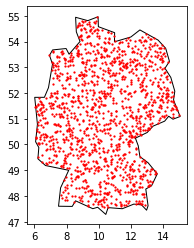

In [10]:
ax = ger.plot(color='white', edgecolor='black')

df.plot(ax=ax, color='red',markersize = 1.5)

## Your typical cross-validation

So your typical cross-validation in sklearn looks like this:

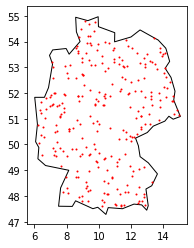

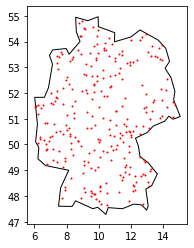

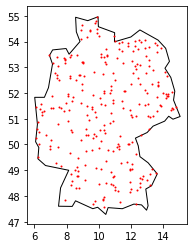

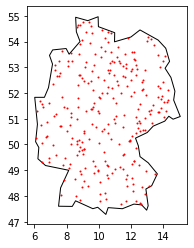

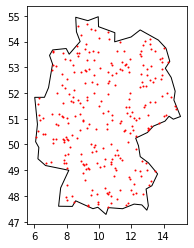

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

for idx, (train_sub_idx, valid_idx) in enumerate(kfold.split(df.values)):
        X_train_sub, X_valid = df.iloc[train_sub_idx], df.iloc[valid_idx]

        gdf2 = geopandas.GeoDataFrame(X_valid, geometry=geopandas.points_from_xy(X_valid.longitude,X_valid.latitude),crs="EPSG:4326")

        ax = ger.plot(color='white', edgecolor='black')

        gdf2.plot(ax=ax, color='red',markersize = 1.0)


We skipped the part were you would split the data in train-/test set and just used the data frame as it makes the point clear. As you can see the validation samples are evenly spaced across our spacial domain. So let's take a look how the blocked cross-validation splits the data.
 

## Spatial adjusted cross-validation

First we create a 5 Fold Cross Validation Iterator, which takes the block size as an argument.

In [21]:
spacing = 1 / 2
random_state = 10
blocked_kfold = vd.BlockKFold(spacing=spacing, shuffle=True, random_state=random_state, n_splits=5)

The spacing is the interesting part, as this controls the block size covered by the folds. Plot your data and try different values. We apply the blocked_kfold iterator on the values of our position. Thats the only difference between the two ways.

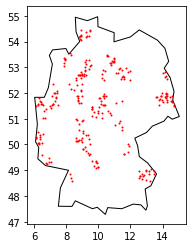

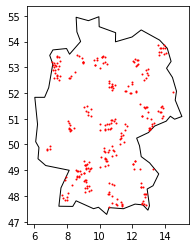

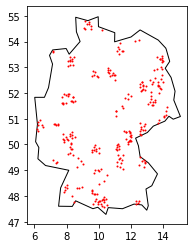

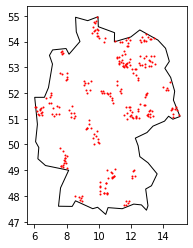

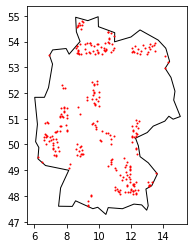

In [22]:
for idx, (train_sub_idx, valid_idx) in enumerate(blocked_kfold.split(df[["latitude","longitude"]].values)):
        X_train_sub, X_valid = df.iloc[train_sub_idx], df.iloc[valid_idx]

        gdf2 = geopandas.GeoDataFrame(X_valid, geometry=geopandas.points_from_xy(X_valid.longitude,X_valid.latitude),crs="EPSG:4326")

        ax = ger.plot(color='white', edgecolor='black')

        gdf2.plot(ax=ax, color='red',markersize = 1.0)


So we managed to create folds which accounts for the spatial dependencies in our data.